Imports

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, GRU, SimpleRNN,
    Dense, Dropout, Flatten, BatchNormalization,
    GlobalAveragePooling2D, LeakyReLU
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dropout, BatchNormalization, Attention, Add, Dense, LeakyReLU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Attention
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
import seaborn as sns

In [2]:
#import tensorflow as tf
#from tensorflow.python.client import device_lib
#print("TensorFlow version:", tf.__version__)
#print("Built with CUDA:", tf.test.is_built_with_cuda())
#print("GPU available via tf.config:", tf.config.list_physical_devices('GPU'))
#print("Available devices:", device_lib.list_local_devices())

Data preprocessing

In [ ]:
df_train_data = pd.read_csv("../data/train_data.csv")
df_train_data = df_train_data.dropna(subset=["text"])
df_train_data.head()

,text,sentiment
0,lol get ideas far advance even june yet need t...,1
1,worst headache ever,0
2,sad wont see miss already yeah thats perfect c...,0
3,doesnt know spell conked,1
4,quotso stand one knows us wont get used wont g...,0


In [ ]:
df_test_data = pd.read_csv("../data/test_data.csv")
df_test_data = df_test_data.dropna(subset=["text"])
df_test_data.head()

,text,sentiment
0,yes black red fav colors really wanted colors ...,0
1,qu buy open house weekend ampm best value one ...,1
2,fran greet air thats okay hahahaha thanks,1
3,omg thats awesome goood luck u meet caaute cal...,1
4,hahahhaha good point,1


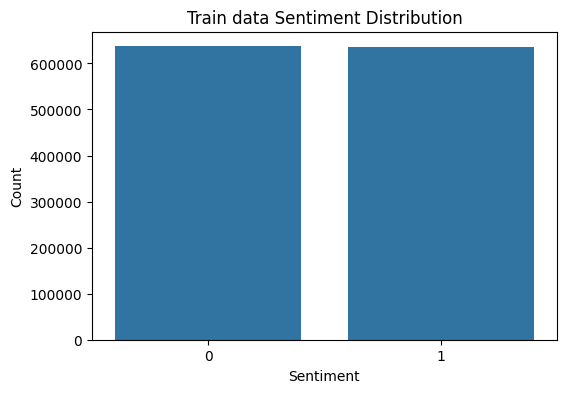

In [5]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_train_data, x="sentiment")
plt.title("Train data Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

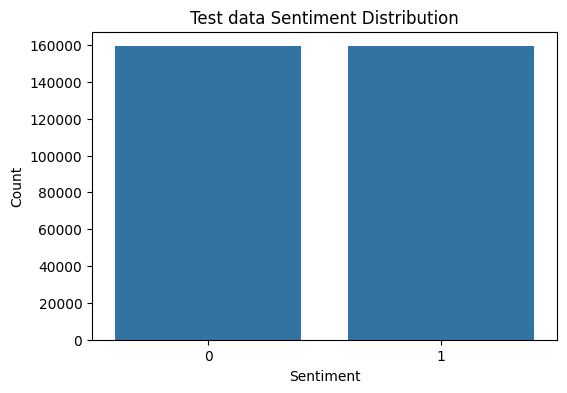

In [6]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_test_data, x="sentiment")
plt.title("Test data Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

Tokenizer

In [7]:
'''
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(df_train_data["text"])
# Frequency-sorted list
word_counts = tokenizer.word_counts  # word -> count dictionary
word_freq_df = pd.DataFrame(word_counts.items(), columns=["word", "count"]).sort_values(by="count", ascending=False)
counts = word_freq_df["count"].values
counts_sorted = np.sort(counts)[::-1]  # Descending

# Cumulative token coverage
total_tokens = counts_sorted.sum()
coverage = np.cumsum(counts_sorted) / total_tokens

# Find cutoff for 95% and 99% coverage
cutoff_95 = np.argmax(coverage >= 0.95)
cutoff_99 = np.argmax(coverage >= 0.99)

print(f"Words needed for 95% coverage: {cutoff_95}")
print(f"Words needed for 99% coverage: {cutoff_99}")
'''

'\ntokenizer = Tokenizer(oov_token="<OOV>")\ntokenizer.fit_on_texts(df_train_data["text"])\n# Frequency-sorted list\nword_counts = tokenizer.word_counts  # word -> count dictionary\nword_freq_df = pd.DataFrame(word_counts.items(), columns=["word", "count"]).sort_values(by="count", ascending=False)\ncounts = word_freq_df["count"].values\ncounts_sorted = np.sort(counts)[::-1]  # Descending\n\n# Cumulative token coverage\ntotal_tokens = counts_sorted.sum()\ncoverage = np.cumsum(counts_sorted) / total_tokens\n\n# Find cutoff for 95% and 99% coverage\ncutoff_95 = np.argmax(coverage >= 0.95)\ncutoff_99 = np.argmax(coverage >= 0.99)\n\nprint(f"Words needed for 95% coverage: {cutoff_95}")\nprint(f"Words needed for 99% coverage: {cutoff_99}")\n'

In [8]:
tokenizer = Tokenizer(num_words=50000, oov_token="<OOV>")
tokenizer.fit_on_texts(df_train_data["text"])

In [9]:
sequences = tokenizer.texts_to_sequences(df_train_data['text'])
test_sequences = tokenizer.texts_to_sequences(df_test_data['text'])

max_len = max(len(seq) for seq in sequences)

X_train = pad_sequences(sequences, maxlen=max_len, padding='post')
X_test = pad_sequences(test_sequences, maxlen=max_len, padding='post')

y_train = df_train_data['sentiment'].values
y_test = df_test_data['sentiment'].values

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

RNN-LSTM Model

In [10]:
# Define the model
model = Sequential([
    Embedding(input_dim=50000, output_dim=64, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32, return_sequences=False)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [11]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Model fit

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)
]

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

Epoch 1/10
15923/15923 ━━━━━━━━━━━━━━━━━━━━ 253s 15ms/step - accuracy: 0.7656 - loss: 0.4805 - val_accuracy: 0.7954 - val_loss: 0.4381 - learning_rate: 0.0010
Epoch 2/10
15923/15923 ━━━━━━━━━━━━━━━━━━━━ 278s 17ms/step - accuracy: 0.8110 - loss: 0.4115 - val_accuracy: 0.7975 - val_loss: 0.4337 - learning_rate: 0.0010
Epoch 3/10
15923/15923 ━━━━━━━━━━━━━━━━━━━━ 304s 16ms/step - accuracy: 0.8286 - loss: 0.3805 - val_accuracy: 0.7958 - val_loss: 0.4395 - learning_rate: 0.0010
Epoch 4/10
15923/15923 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8460 - loss: 0.3488
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
15923/15923 ━━━━━━━━━━━━━━━━━━━━ 281s 17ms/step - accuracy: 0.8460 - loss: 0.3488 - val_accuracy: 0.7912 - val_loss: 0.4538 - learning_rate: 0.0010
Epoch 5/10
15923/15923 ━━━━━━━━━━━━━━━━━━━━ 324s 17ms/step - accuracy: 0.8689 - loss: 0.3042 - val_accuracy: 0.7835 - val_loss: 0.5270 - learning_rate: 2.0000e-04


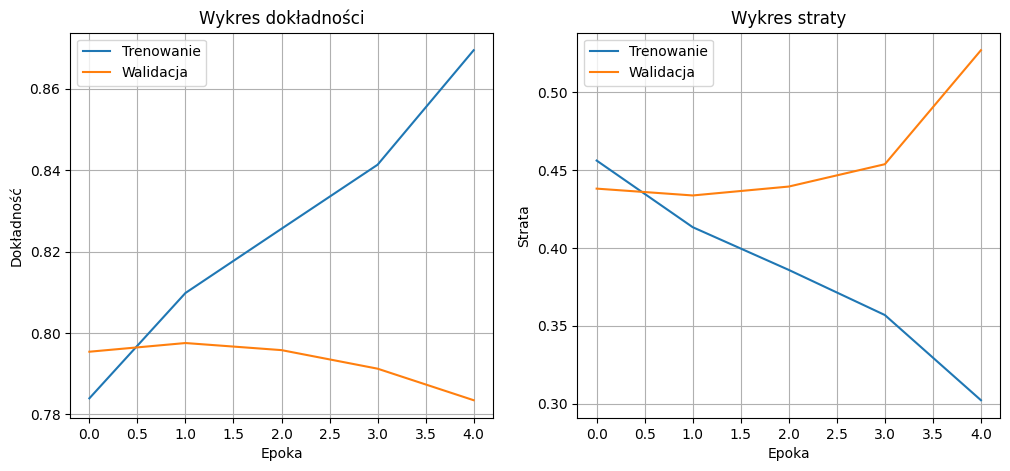

In [13]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Trenowanie')
plt.plot(history.history['val_accuracy'], label='Walidacja')
plt.title('Wykres dokładności')
plt.grid(True)
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Trenowanie')
plt.plot(history.history['val_loss'], label='Walidacja')
plt.title('Wykres straty')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.grid(True)
plt.legend()

plt.show()

Model predict

In [14]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'\nDokładność na danych testowych: {test_acc:.4f}')

9953/9953 ━━━━━━━━━━━━━━━━━━━━ 58s 6ms/step - accuracy: 0.7992 - loss: 0.4320

Dokładność na danych testowych: 0.7993


9953/9953 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step
Accuracy: 0.7993450179287998
[[124898  34344]
 [ 29561 129679]]
              precision    recall  f1-score   support

           0       0.81      0.78      0.80    159242
           1       0.79      0.81      0.80    159240

    accuracy                           0.80    318482
   macro avg       0.80      0.80      0.80    318482
weighted avg       0.80      0.80      0.80    318482



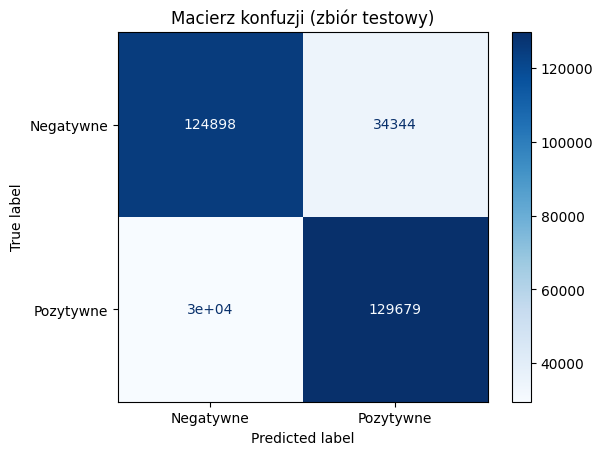

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred_binary))
print(confusion_matrix(y_test, y_pred_binary))
print(classification_report(y_test, y_pred_binary))

cm = confusion_matrix(y_test, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negatywne", "Pozytywne"])
disp.plot(cmap='Blues')
plt.title('Macierz konfuzji (zbiór testowy)')
plt.show()

In [16]:
'''
model = Sequential([
    Embedding(input_dim=100000, output_dim=200, input_length=max_len),
    LSTM(128, return_sequences=True),
    Dropout(0.5),
    LSTM(128),
    Dense(64, activation='relu',
          kernel_regularizer=regularizers.l2(0.01),
          activity_regularizer=regularizers.l1(0.01)),
    Dense(2, activation='softmax')
])
'''

"\nmodel = Sequential([\n    Embedding(input_dim=100000, output_dim=200, input_length=max_len),\n    LSTM(128, return_sequences=True),\n    Dropout(0.5),\n    LSTM(128),\n    Dense(64, activation='relu',\n          kernel_regularizer=regularizers.l2(0.01),\n          activity_regularizer=regularizers.l1(0.01)),\n    Dense(2, activation='softmax')\n])\n"

In [17]:
'''
def lstm_block(x, units, return_sequences=False, dp=0.4):
    residual = x
    # Bidirectional LSTM
    x = Bidirectional(LSTM(units, return_sequences=True, kernel_regularizer=l2(0.001)))(x)
    x = Dropout(dp)(x)
    x = BatchNormalization()(x)

    attention = Attention()([x, x])
    x = Add()([x, attention])

    if residual.shape[-1] != x.shape[-1]:
        residual = Dense(x.shape[-1])(residual)
    x = Add()([x, residual])

    if not return_sequences:
        x = GlobalAveragePooling1D()(x)

    return x

from tensorflow.keras.layers import Embedding

def model_lstm_with_embedding(input_shape, vocab_size=100000, embedding_dim=100):
    inputs = Input(shape=input_shape)

    # Embedding
    x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_shape[0])(inputs)

    # LSTM
    #x = lstm_block(x, 512, return_sequences=True)
    x = lstm_block(x, 256, return_sequences=True)
    x = lstm_block(x, 128, return_sequences=True)
    x = lstm_block(x, 64, return_sequences=False)
    #x = lstm_block(x, 32, return_sequences=False)

    # Dense
    for units, rate in [(256, 0.4), (128, 0.4)]: #(512, 0.4), (64, 0.3)
        x = Dense(units)(x)
        x = LeakyReLU()(x)  # Leaky ReLU aktivasyon
        x = Dropout(rate)(x)


    outputs = Dense(1, activation="sigmoid")(x)

    model = Model(inputs, outputs)

    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = model_lstm_with_embedding((max_len,))
'''

'\ndef lstm_block(x, units, return_sequences=False, dp=0.4):\n    residual = x\n    # Bidirectional LSTM\n    x = Bidirectional(LSTM(units, return_sequences=True, kernel_regularizer=l2(0.001)))(x)\n    x = Dropout(dp)(x)\n    x = BatchNormalization()(x)\n\n    attention = Attention()([x, x])\n    x = Add()([x, attention])\n\n    if residual.shape[-1] != x.shape[-1]:\n        residual = Dense(x.shape[-1])(residual)\n    x = Add()([x, residual])\n\n    if not return_sequences:\n        x = GlobalAveragePooling1D()(x)\n\n    return x\n\nfrom tensorflow.keras.layers import Embedding\n\ndef model_lstm_with_embedding(input_shape, vocab_size=100000, embedding_dim=100):\n    inputs = Input(shape=input_shape)\n\n    # Embedding\n    x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_shape[0])(inputs)\n\n    # LSTM\n    #x = lstm_block(x, 512, return_sequences=True)\n    x = lstm_block(x, 256, return_sequences=True)\n    x = lstm_block(x, 128, return_sequences=True)